In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score

In [3]:
# This block will apply some preprocess on images of train, val and test dataset

transform = {
    "train": transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
        transforms.Resize((64, 64)),  # Resize to 64x64 as per model need
        transforms.RandomCrop(64, padding=4),  # Random crop with padding
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # This will change brightness of the image
        transforms.ToTensor(),  
        transforms.Normalize(mean=[0.5], std=[0.5])  # This will help to normalize the image
    ]),
    
    "val": transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]),
    
    "test": transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
}

In [4]:
# Location of the dataset and sub directories like train, test and val directory
data_dir = r"C:\Users\bhalani\Animal_classification\Dataset\Dataset"  
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

# This will Load datasets using ImageFolder
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform["train"])
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform["val"])
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform["test"])

# Define the batch size (As dataset small batch size 8 is taken)
batch_size = 8

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

print("Class-to-Index Mapping:", train_dataset.class_to_idx)

Class-to-Index Mapping: {'cat': 0, 'dog': 1}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


labels: tensor([1, 1, 0, 1, 0, 1, 1, 1])


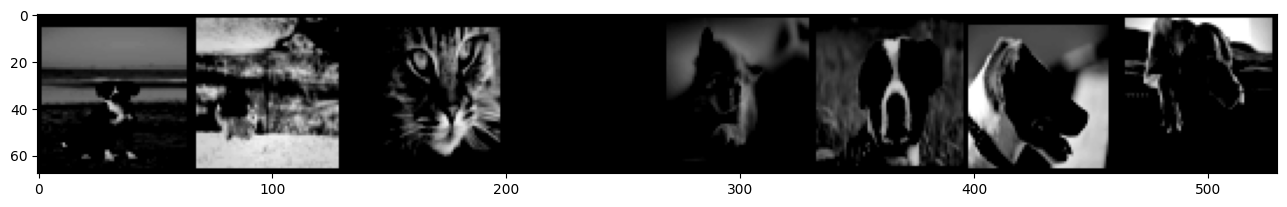

In [5]:
# This block will plot the one batch of the image to visulize how images will look like after preprocessing

samples, labels = next(iter(DataLoader(train_dataset, batch_size=8, shuffle=True)))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
print(f'labels: {labels}')

In [ ]:
# Resnet18 Model construction (changes are mentioned in comments)

# Here is basicblock for ResNet18 which is also known as residual network.
# The main purpose of a residual block is ease the training of deep neural networks 
# by allowing gradients to flow through the network more effectively, 
# addressing the vanishing gradient problem.

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        # Here is Skip Connection:
        # Element-wise addition of input (identity) and residual (out).
        # This improves gradient flow and prevents them from becoming too small during backpropagation, 
        # which is a common issue in very deep networks.
        out += identity
        out = self.relu(out)

        return out

class ResNet18(nn.Module):
    def __init__(self, num_classes=2): # number of classes is 2 taken as it is binary classification (cat vs dog)
        super(ResNet18, self).__init__()
        self.in_channels = 64
        
        # input channel is 1 taken instead of 3 as input image is in grayscale
        # Changed the kernel size from 3 to 7 in the first Conv layer to look at a bigger part of the image at once. 
        # As image is resized to 64x64 from very high dimentions, This will helps the model catch more patterns and details right from the start. 
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.bn1 = nn.BatchNorm2d(64)
        
        # Added Maxpool layer this will help to reduce computational cost and it makes the feature maps even smaller while keeping the most important features. 
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.linear = nn.Linear(512 * BasicBlock.expansion, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            # Downsampling is needed if spatial dimensions or channels change, 
            # to ensure the skip connection has matching dimensions.
            # A 1x1 convolution adjusts channels and stride handles downsampling,
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = F.avg_pool2d(x, 2) # kernal size has been 2x2 taken to match dimension insted of  default 4x4
        x = torch.flatten(x, 1)
        x = self.linear(x)

        return x

In [7]:
# This bolck creates training loop


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Model
model = ResNet18(num_classes=2).to(device)

# Loss function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training Function
def train_model(model, trainloader, valloader, num_epochs, save_dir=r'C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints'):
    train_losses = []
    val_losses = []
    val_f1_scores = []
    val_accuracies = []

    os.makedirs(save_dir, exist_ok=True)

    # Initialize best loss to a large value
    best_val_loss = float('inf')
    best_model_path = None

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(trainloader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            for images, labels in valloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                preds = torch.argmax(outputs, dim=1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.cpu().numpy())

        val_loss /= len(valloader)
        val_losses.append(val_loss)

        # This will Compute F1 Score & Accuracy with the help of scikit-learn's predifined functions
        val_f1 = f1_score(all_labels, all_preds, average="macro")
        val_acc = accuracy_score(all_labels, all_preds)

        val_f1_scores.append(val_f1)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # This will save the model every time if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(save_dir, f"best_model_epoch_{epoch+1}.pth")
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved at: {best_model_path}")
    
    # This method will plot training loss and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker="o")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")
    loss_plot_path = os.path.join(r'C:\Users\bhalani\Animal_classification\Animal-classification\Result_plots', 'loss_curve.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot saved at: {loss_plot_path}")

    # This method will plot Validation Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), val_accuracies, label="Val Accuracy", marker="o", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")
    acc_plot_path = os.path.join(r'C:\Users\bhalani\Animal_classification\Animal-classification\Result_plots', 'val_accuracy_curve.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f"Validation accuracy plot saved at: {acc_plot_path}")

    # This method will plot Validation F1 Score
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), val_f1_scores, label="Val F1 Score", marker="o", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.legend()
    plt.title("Validation F1 Score")
    f1_plot_path = os.path.join(r'C:\Users\bhalani\Animal_classification\Animal-classification\Result_plots', 'val_f1_curve.png')
    plt.savefig(f1_plot_path)
    plt.close()
    print(f"Validation F1 Score plot saved at: {f1_plot_path}")

    return best_model_path
        
best_model_path = train_model(model, trainloader, valloader, num_epochs=20)

# This will print the absolute path of the saved best model after training
if best_model_path:
    print(f"Best model checkpoint saved at: {os.path.abspath(best_model_path)}")
    

Epoch [1/20] - Train Loss: 0.7038, Val Loss: 0.4502, Val Acc: 0.8095, Val F1: 0.6754
Best model saved at: C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_1.pth
Epoch [2/20] - Train Loss: 0.6311, Val Loss: 0.4411, Val Acc: 0.8155, Val F1: 0.5866
Best model saved at: C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_2.pth
Epoch [3/20] - Train Loss: 0.5724, Val Loss: 0.2863, Val Acc: 0.9077, Val F1: 0.8277
Best model saved at: C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_3.pth
Epoch [4/20] - Train Loss: 0.4810, Val Loss: 0.3659, Val Acc: 0.8393, Val F1: 0.7890
Epoch [5/20] - Train Loss: 0.4350, Val Loss: 0.1707, Val Acc: 0.9494, Val F1: 0.9108
Best model saved at: C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_5.pth
Epoch [6/20] - Train Loss: 0.3939, Val Loss: 0.1972, Val Acc: 0.9196, Val F1: 0.8705
Epoch [7/20] - Train L

In [9]:
# This function will test our model using best checkpoint path and provides multiple performance score also print the predicted class and confidence score 

def evaluate_model(model, testloader, checkpoint_path=r"C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_20.pth"):
    # Load the best saved model
    print(f"Loading model from: {checkpoint_path}")
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []

    # Class names (for mapping)
    class_names = ['Cat', 'Dog']

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            confidences, preds = torch.max(probs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Output predicted class and confidence score
            for i in range(len(preds)):
                predicted_class = class_names[preds[i].item()]
                confidence_score = confidences[i].item() * 100  # Convert to percentage
                print(f"Predicted: {predicted_class}, Confidence: {confidence_score:.2f}%")

  
    test_f1 = f1_score(all_labels, all_preds, average="macro")
    test_acc = accuracy_score(all_labels, all_preds)
    tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
    precision_sklearn = precision_score(all_labels, all_preds, average="macro")
    recall_sklearn = recall_score(all_labels, all_preds, average="macro")

    print(f"\n Test Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}")
    print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"Precision: {precision_sklearn:.4f}, Recall: {recall_sklearn:.4f}")


In [10]:
# Evaluate the model on test set
evaluate_model(model, testloader)

Loading model from: C:\Users\bhalani\Animal_classification\Animal-classification\checkpoints\best_model_epoch_20.pth
Predicted: Cat, Confidence: 99.97%
Predicted: Cat, Confidence: 99.96%
Predicted: Cat, Confidence: 96.42%
Predicted: Cat, Confidence: 56.33%
Predicted: Cat, Confidence: 99.46%
Predicted: Cat, Confidence: 99.42%
Predicted: Cat, Confidence: 93.93%
Predicted: Cat, Confidence: 98.92%
Predicted: Cat, Confidence: 99.25%
Predicted: Cat, Confidence: 99.97%
Predicted: Cat, Confidence: 98.81%
Predicted: Cat, Confidence: 99.34%
Predicted: Cat, Confidence: 95.97%
Predicted: Cat, Confidence: 99.49%
Predicted: Cat, Confidence: 98.18%
Predicted: Cat, Confidence: 99.70%
Predicted: Cat, Confidence: 99.95%
Predicted: Cat, Confidence: 99.63%
Predicted: Cat, Confidence: 98.82%
Predicted: Cat, Confidence: 99.28%
Predicted: Cat, Confidence: 99.56%
Predicted: Cat, Confidence: 97.65%
Predicted: Cat, Confidence: 100.00%
Predicted: Cat, Confidence: 99.83%
Predicted: Cat, Confidence: 67.93%
Predict